## Understanding autoEAP workflow

The details of autoEAP are published here: Bódi et al., 2021, PASP, accepted

The details of Extended Aperture Photometry are published here: https://ui.adsabs.harvard.edu/abs/2019ApJS..244...32P/abstract

A short summary of automatization is published here: https://ui.adsabs.harvard.edu/abs/2020arXiv200908786P/abstract

As an example, you can download a TPF from MAST.

In [1]:
import autoeap

targetID = 'EPIC 251812081'
campaign = 18

To get through the steps, you have to set `show_plots` to `True`. Or, if you wish to save the plots into a directory, you can set `save_plots` to `True`.

Local TPF not found, trying to download TPF instead
TPF found on MAST: K2 Campaign 18
Finding PSF centroids and removing outliers


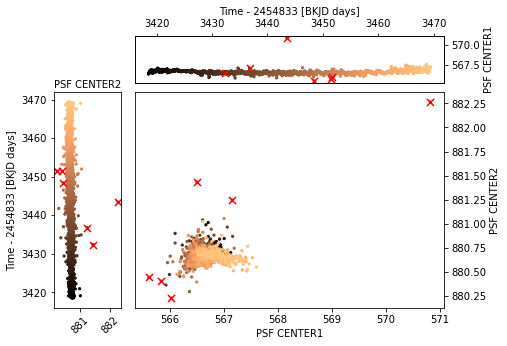

  0%|          | 0/2409 [00:00<?, ?it/s]

Optimizing apertures for each cadence


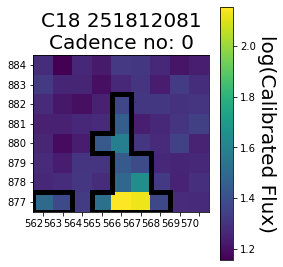

 41%|████▏     | 994/2409 [00:02<00:03, 424.17it/s]

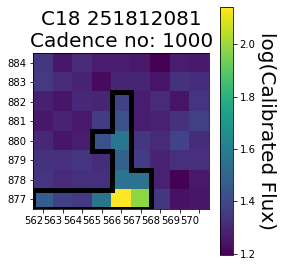

 82%|████████▏ | 1973/2409 [00:05<00:01, 383.51it/s]

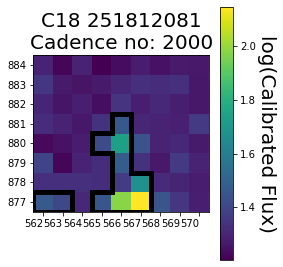

100%|██████████| 2409/2409 [00:06<00:00, 380.05it/s]


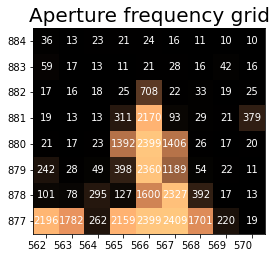

Starting iteration


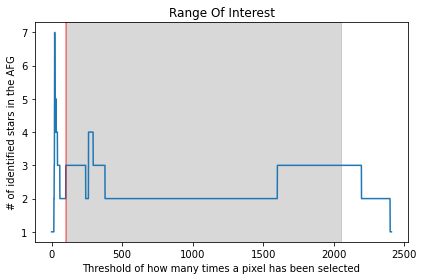

Using Gaia to separate sources


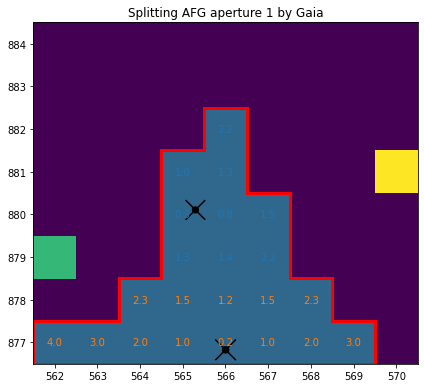

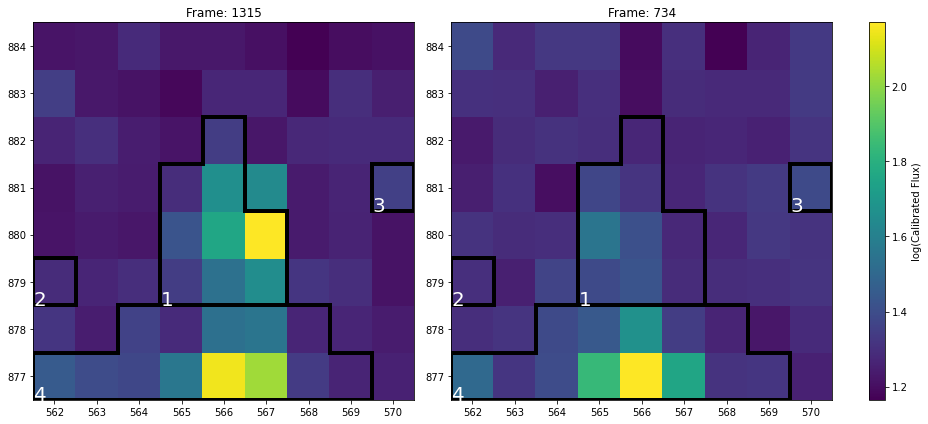

Iteration: 1


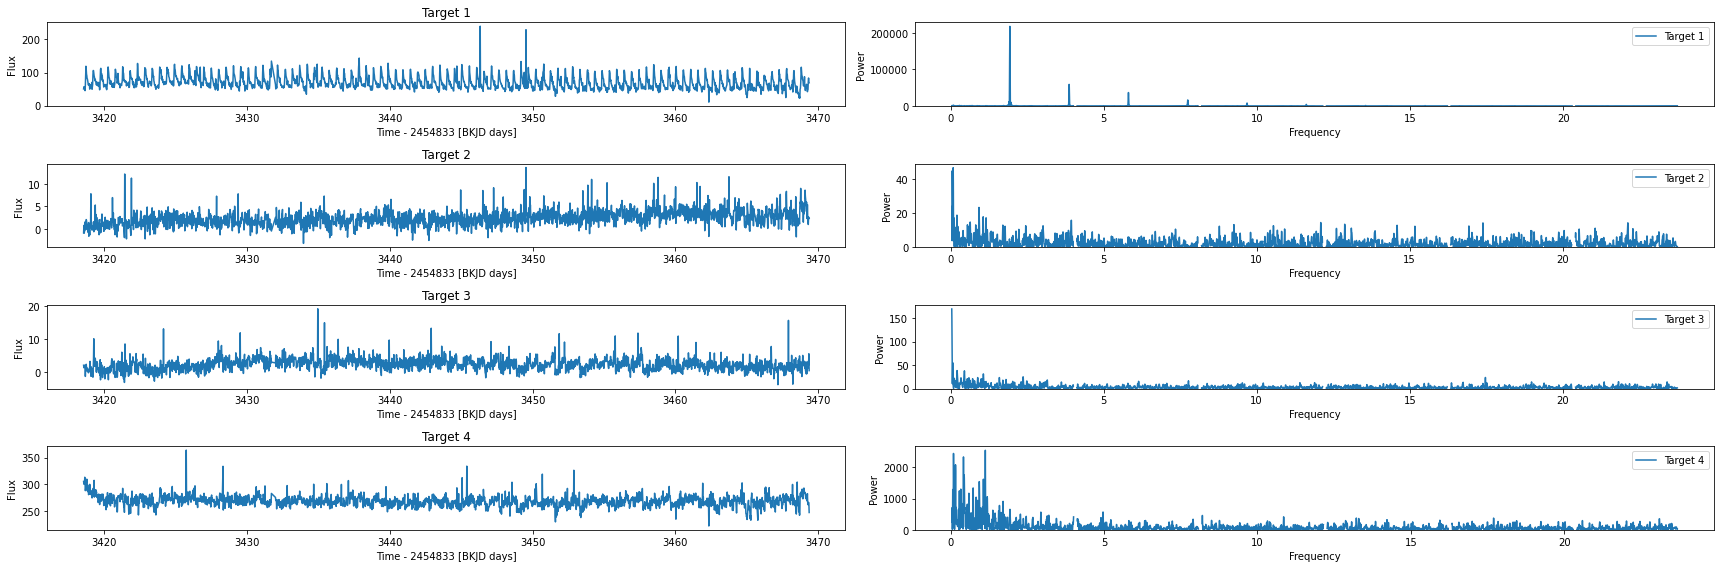

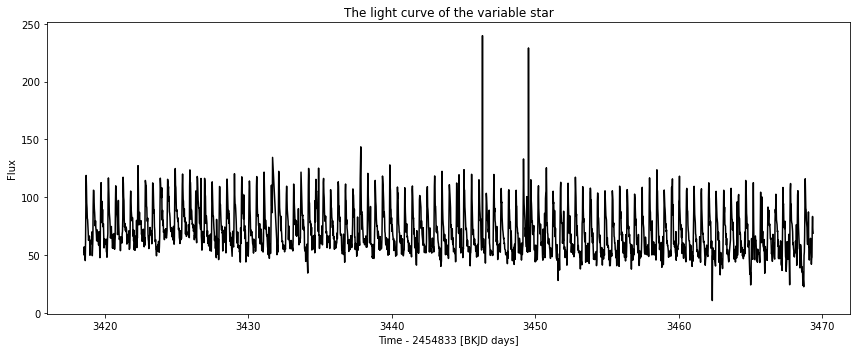

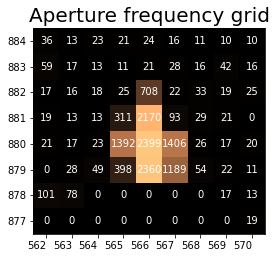

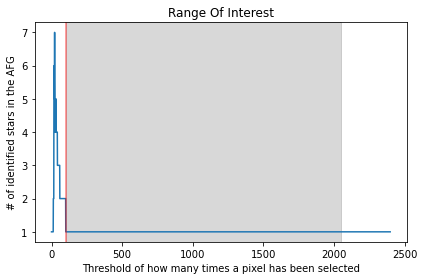

Using Gaia to separate sources


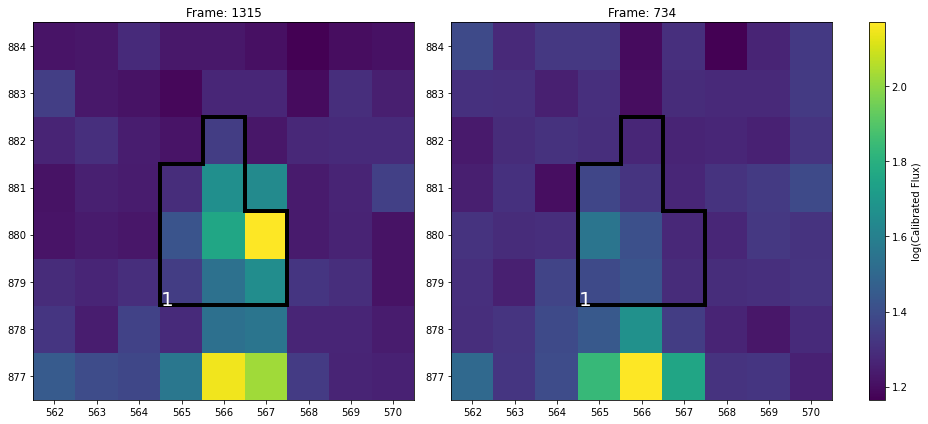

Iteration: 2


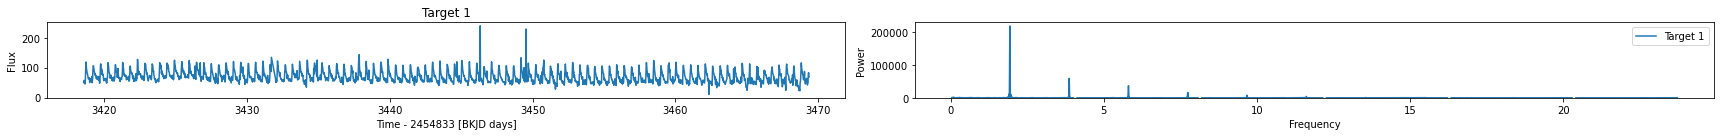

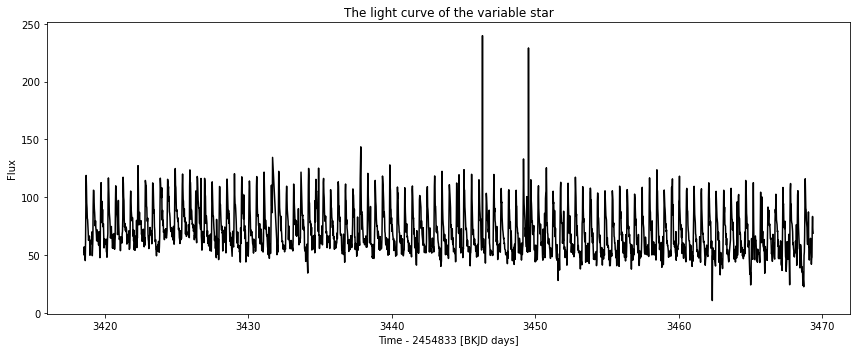

Iteration finished
Optimizing final aperture
Initial PDM theta = 0.5183
Keeping aperture with initial PDM
Final aperture:


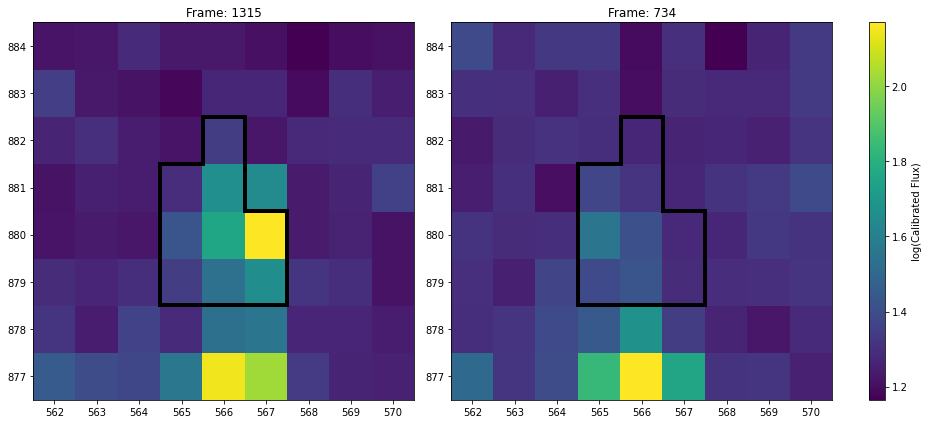

Done


In [2]:
time,flux,flux_err = autoeap.createlightcurve(
        targetID,              # Path to TPF or EPIC ID
        apply_K2SC=False,      # Apply K2 systematic correction
        detrend=False,         # Fit and remove low-order spline
        save_lc=False,         # Save final light curve to file
        campaign=campaign,     # K2 campaign number if TPF should be downloaded
        show_plots=True,       # Vizualize steps inside notebook
        save_plots=False,      # Save plot files in a separate folder
        save_aperture=False,   # Save the final aperture to a FITS file
        polyorder='auto',      # The order of the detrending polynomial
        sigma_detrend=10,      # The number of standard deviations to use for sigma clipping limit before spline correction
        TH=8,                  # Empirically determined tuning parameter
        ROI_lower=100,         # AFG range of interest lower limit in candence number
        ROI_upper=0.85         # AFG range of interest upper limit in ratio of number of cadences
        )

## The meaning of plots are as follows:

- The PSF photocenter movement. The upper and left hand side plots show the centroid movement in X and Y directions by time, respectively. The middle panel shows the CCD area visited by the centroid. The outlier points, marked by red, are indentified using Density-based spatial clustering of applications with noise (DBSCAN) algorithm. These points are excluded during the following steps.

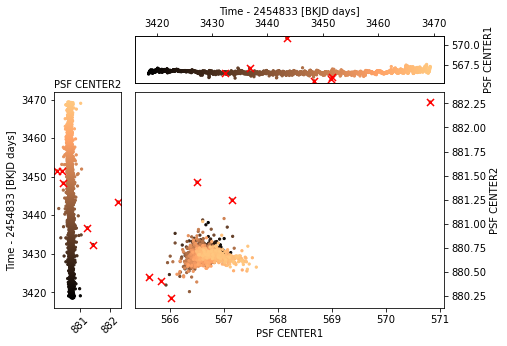

- Now, we loop over all cadences and separate the stars one-by-one. Here, you can see the separated sources in case of the first cadence (we are using zero-based indices). We plot this for every 1000th candences to visualize PSF delocation due to the telescope movement. The target separation is done using Astropy's photutils.

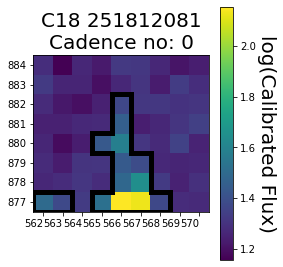

- After we know the location of the targets for each candence, we can count how many times each pixel was selected. We dubbed this metric as aperture frequency grid (AFG).

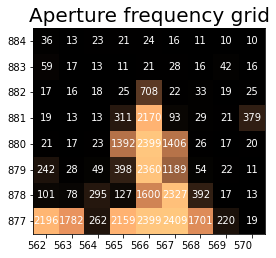

- In the AFG, we have to separate the distinct features that (probably) correspond to different stars. To do so, we set a threshold for the number of selection times (which is given for each pixel). Then, we only consider AFG values above this level and separate the features. The number of separated stars versus this threshold is plotted in the figure below. The limit runs from 0 to the number of cadences. We empirically tested and set an optimal range, between 100 and the 85th percentile of the maximum, which is used to find the best separation. We have to balance the number of targets and the selected pixel area per target, not dividing the TPF into too many portions, and keeping the selected area per target as large as possible to maximize the signal to noise ratio and to capture all incident fluxes.

- The threshold is at where the second upward jump is detected, however, if there is none, we use the maximum AFG value divided by TH. The TH value is an empirically determined value, and is set to 8 by default.
In this case we can see only one upward jump before a downward one appears, thus we select that one.

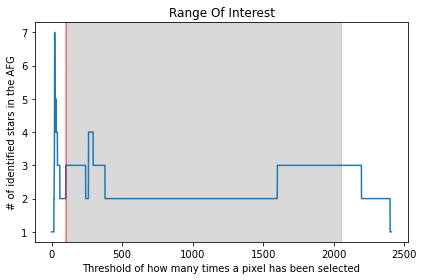

- To make sure we separated all targets photometrically, we cross match the location of stars with the Gaia catalog. If there are more than one (probably) detectable source in a given aperture, then the aperture is divided into smaller portions. In this figure, the numbers show the brightness weighted distance of the given pixel from the closest source.

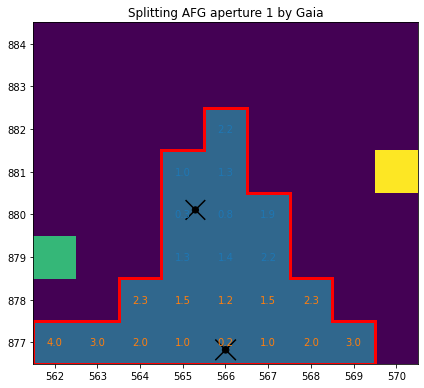

- And we get the separated features, which are overplotted in case of two images, where the telescope position is at its extremes.

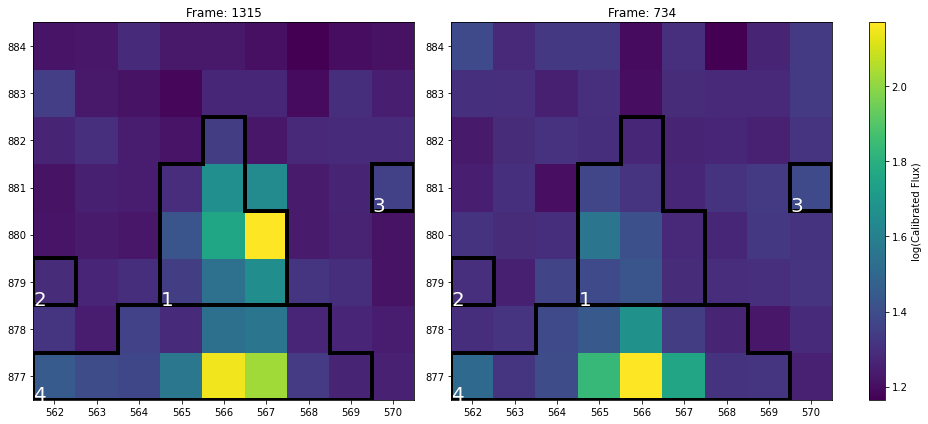

- As we do not know which one is the variable star, we have to perform an initial photometry for each of them. Then, we use Lomb-Scargle analysis to select the variable star, the one that has the largest amplitude variability (here it is target 1).

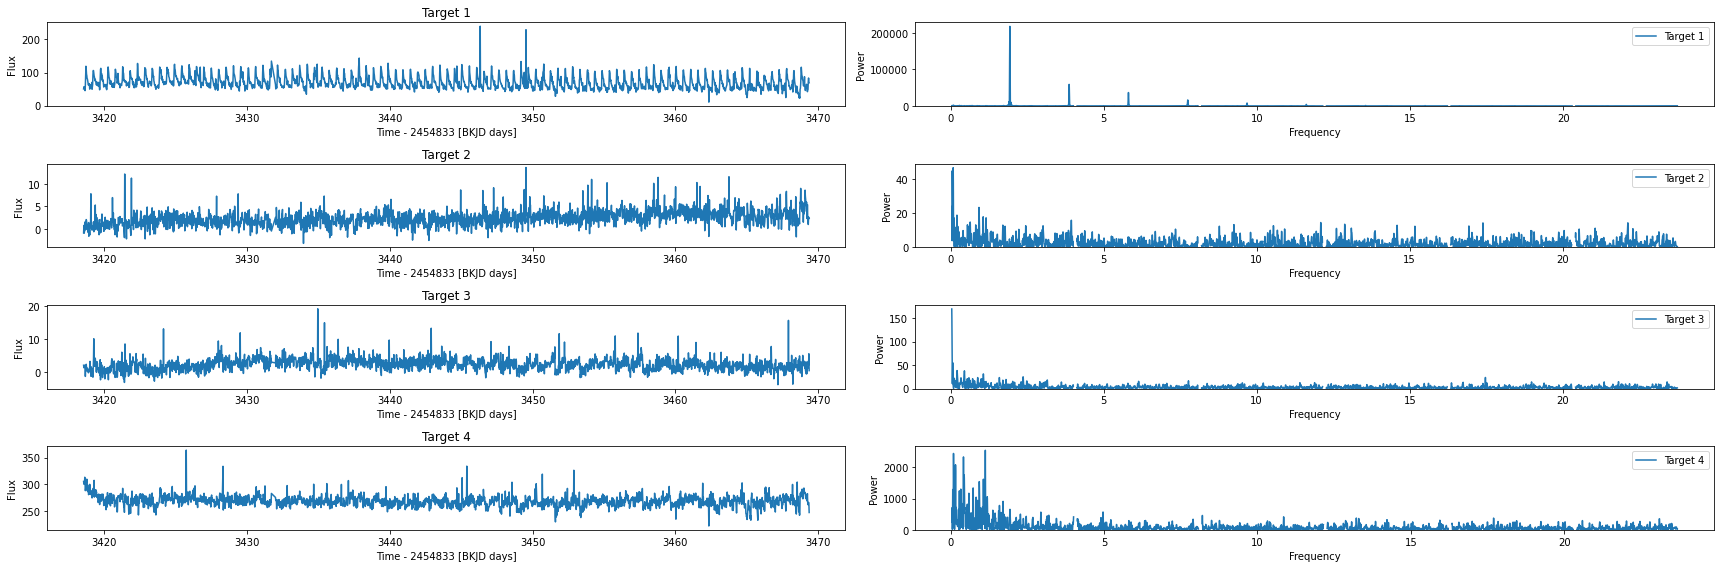


- And the proposed light curve.

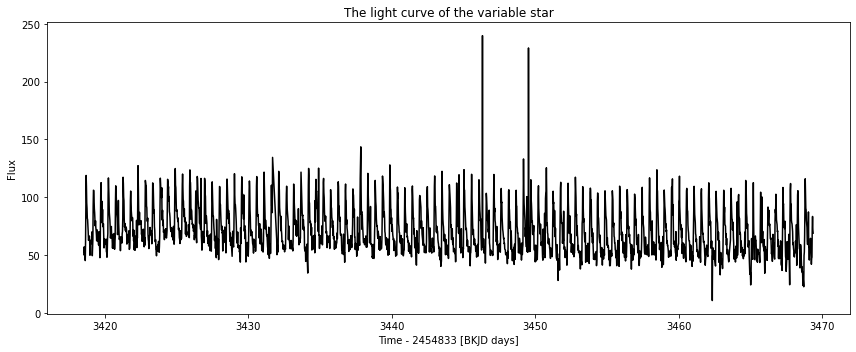

- After we know the location of AFG pixels that contain our variable star, we can eliminate the others. Just set those AFG values to 0.

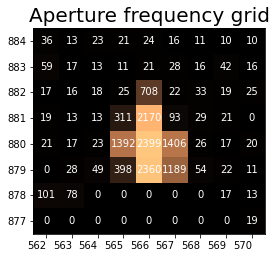

- And the search starts again, and continues until one only target remains...